In [1]:
import glob
import os
import cv2
import numpy as np

In [2]:
#モデルを読み込む
face_detector = cv2.FaceDetectorYN_create("../models/yunet.onnx", "", (0, 0))
face_recognizer = cv2.FaceRecognizerSF_create("../models/face_recognizer_fast.onnx", "")

[ERROR:0@0.488] global /io/opencv/modules/dnn/src/onnx/onnx_importer.cpp (2516) parseShape DNN/ONNX(Shape): dynamic 'zero' shapes are not supported, input 243 [ 0 0 0 51 ]
[ERROR:0@0.491] global /io/opencv/modules/dnn/src/onnx/onnx_importer.cpp (2516) parseShape DNN/ONNX(Shape): dynamic 'zero' shapes are not supported, input 250 [ 0 0 0 34 ]
[ERROR:0@0.491] global /io/opencv/modules/dnn/src/onnx/onnx_importer.cpp (2516) parseShape DNN/ONNX(Shape): dynamic 'zero' shapes are not supported, input 257 [ 0 0 0 34 ]
[ERROR:0@0.492] global /io/opencv/modules/dnn/src/onnx/onnx_importer.cpp (2516) parseShape DNN/ONNX(Shape): dynamic 'zero' shapes are not supported, input 264 [ 0 0 0 51 ]
[ERROR:0@0.492] global /io/opencv/modules/dnn/src/onnx/onnx_importer.cpp (2516) parseShape DNN/ONNX(Shape): dynamic 'zero' shapes are not supported, input 297 [ 0 -4 ]


In [3]:
#画像のサイズを指定して読み込む
image = cv2.imread("../cancan.jpg")
hight, width, _ = image.shape
face_detector.setInputSize((width, hight))

In [4]:
#顔を検出する
_, faces = face_detector.detect(image)
faces = faces if faces is not None else[]

In [5]:
#特徴を読み込む
dictionary = []
files = glob.glob(os.path.join(os.path.dirname("face001.npy"),"*.npy"))
for file in files:
    feature = np.load(file)
    user_id = os.path.splitext(os.path.basename(file))[0]
    dictionary.append((user_id, feature))

In [6]:
COUSINE_THRESHOLD = 0.363
NORML2_THRESHOLD = 1.128
#特徴と辞書を比較してマッチしたユーザーとスコアを返す
def match(recognizer, feature1, dictionary):
    for element in dictionary:
        user_id, feature2 = element
        score = recognizer.match(feature1, feature2, cv2.FaceRecognizerSF_FR_COSINE)
        if score > COUSINE_THRESHOLD:
            return True, (user_id, score)
    return False,("", 0.0)

In [7]:
for face in faces:
    #検出された顔を切り抜く
    aligned_face = face_recognizer.alignCrop(image, face)
    #顔の特徴を検出する
    face_feature = face_recognizer.feature(aligned_face)
    #辞書とマッチングする
    result, user = match(face_recognizer, face_feature, dictionary)
    #顔のバウンディングボックスを描画する
    box = list(map(int, face[:4]))
    color = (0, 255, 0) if result else (0, 0, 255)
    thickness = 2
    cv2.rectangle(image, box, color, thickness, cv2.LINE_AA)

    #認識の結果を描画する
    id, score = user if result else ("unknown", 0.0)
    text = "{0} ({1:.2f})".format(id, score)
    position = (box[0], box[1] - 10)
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.6
    cv2.putText(image, text, position, font, scale, color, thickness, cv2.LINE_AA)

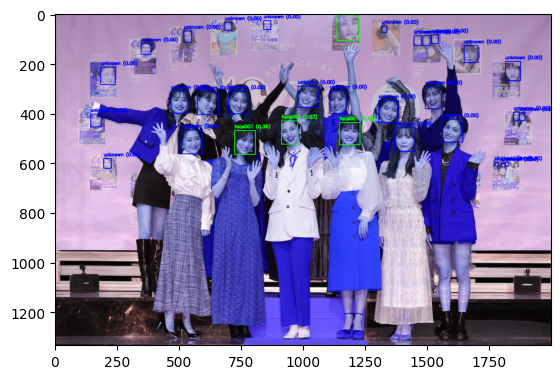

In [8]:
#画像を表示する
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(image)
plt.show()